# Analysis of the primary energy consumption of the USA since 1850

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

This data was gathered from ‘‘Estimated Energy Consumption in the United States, Selected Years, 1635–1945’’ (EIA 2011) and ‘‘Energy Consumption, Expenditures, and Emissions Indicators, 1949–2012’’ (EIA 2012)

In [3]:
USA = pd.read_csv('../BDD/USA-1850-2008.csv', sep=';')
USA=USA.dropna()
USA.head()

,Year,TotPEC(QuadrillionBTU),GDP(1990GK$),Pop(000)
0,1850.0,2.357,42583.0,23579.7179
1,1860.0,3.162,69346.0,31838.9007
2,1870.0,3.952,98374.0,40240.6295
3,1875.0,4.323,117573.0,45245.0000
4,1880.0,5.001,160656.0,50458.0000


## S-curve Model of Relationship Between Energy Consumption and Economic Development (Wang et Al, 2014)

As shown in Wang et Al. article, the raltionship between GDP per capita and primary energy per capita can peu modelled by a s function. Each phase can be interpreted from an industrial and historical point of view (at least for developed countries). 
In the article, the result of the regression of the S-Curves is given as well as some mathematical elements to allow this regression. 

In this section, I try to reproduce the regression of an S-Curve function which fits with the US data. 

In [4]:
PEC = USA['TotPEC(QuadrillionBTU)']*(2.518272*10**4)
GDP = USA['GDP(1990GK$)']*1000
pop = USA['Pop(000)']

On the cell below, I implement the function estimated in the article.

Text(0, 0.5, 'per Capita energy consumption,Toe')

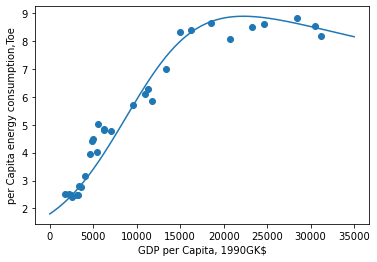

In [5]:
def wang(G) :
    E=5.7+5.6*(exp(8*(10**-5)*(G-9600))-exp(-1.05*(10**-4)*(G-9600)))/(2*cosh(1.12*(10**-4)*(G-9600)))
    return E
plt.scatter(GDP/pop, PEC/pop)
plt.plot(np.arange(35000), [wang(G) for G in np.arange(35000)])
plt.xlabel('GDP per Capita, 1990GK$')
plt.ylabel('per Capita energy consumption,Toe')

Now I try to reproduce the results of the article. Thus I will have a program which will allow me to regress S-Curves on all the data available and thus to analyze them regarding historical and technical elements. 

In [6]:
import math as math
def f(A, eth_1, eth_2, eth_3) :
    return math.tanh(eth_1/A)*math.tanh(eth_2/A)-eth_3

def find_A(A_min, A_max, eth_1, eth_2, eth_3, epsilon=10**-3) :
    """
    This function based on dichotomy allows me to estimate the value of A variable (cf article)
    """
    while A_max-A_min > epsilon :
        A = (A_min+A_max)/2
        if f(A, eth_1, eth_2, eth_3) ==0 :
            return A  
        elif f(A_min, eth_1, eth_2, eth_3)*f(A_max, eth_1, eth_2, eth_3)< 0:
            A_max =A
        else :
            A_min = A

    return (A_min+A_max)/2

In [7]:
import sympy as sy
def remarking_points(G, E, deg = 6, step = 0.1) : 
    """
    This function returns the inflexion point, the zero_growth point and the take-off point of f where (f(g) = e) thanks to the data points
    degree: int, degree of the polynomial regression, default value 6 
    step: step used for the estimation of the inflexion point 
    """
    # regression of a polynomial function
    G = G[:, np.newaxis]
    E = E[:, np.newaxis]
    polynomial_features= PolynomialFeatures(degree=deg)
    G_poly = polynomial_features.fit_transform(G)
    model = LinearRegression()
    model.fit(G_poly, E)
    y_poly_pred = model.predict(G_poly) 

    # computing numerous points to improve our prediction
    max_gdp = np.amax(np.array(G))
    G_calc = np.arange(0, max_gdp, step)
    G_calc = G_calc[:, np.newaxis]
    G_calc_poly = polynomial_features.fit_transform(G_calc)

    E_poly_pred_calc = model.predict(G_calc_poly )
    E_poly_pred_calc = np.array([E_poly_pred_calc[i][0] for i in range(len(E_poly_pred_calc))])

    #inflexion point
    idx_infl = int(np.diff(E_poly_pred_calc[4:] ).argmax())
    G_i = G_calc[idx_infl][0]
    G_dist = np.array([abs(g-G_i) for g in G])
    id_i = G_dist.argmin()
    E_i = E[id_i][0]

    # zero-growth point 
    zero_growth_idx = np.abs(np.diff(E_poly_pred_calc[idx_infl:])).argmin()
    G_z = G_calc[zero_growth_idx][0]
    G_dist = np.array([abs(g-G_z) for g in G])
    id_z = G_dist.argmin()-1
    E_z = E[id_z][0]


    # Take-off point 
    to_idx =np.diff(np.diff(E_poly_pred_calc))[0:idx_infl].argmax()
    G_t = G_calc[to_idx][0]
    G_dist = np.array([abs(g-G_t) for g in G])
    id_t = G_dist.argmin()
    E_t = E[id_t][0]

    # slope before the take-off point kl
    kl = (E_t-E[0])/(G_t-G[0])[0]
    # slope between take-off point and the zero-growth point ki
    ki = (E_z-E_t)/(G_z-G_t)
    # slope after the zero-growth point kv
    n = len(G)-1
    kv = (E[n]-E_z)/(G[n]-G_z)[0]

    # parameters
    eth_1 = 0.5*(ki+kl+kv)*(G_z-G_i)
    eth_2 = 0.5*(kl+2*ki-kv)*(G_z-G_i)
    eth_3 = (kl+ki+kv)/(kl+2*ki-kv)
    
    A = find_A(1,10, eth_1, eth_2, eth_3)

    alpha_1 = (kl+ki+kv)/(2*A)
    alpha_2 = (kl+2*ki-kv)/(2*A)
    alpha_3 = (-kl+2*ki-kv)/(2*A)


    return {'inflexion' : (G_i,E_i), 'zero_growth':(G_z,E_z), 'take_off' : (G_t, E_t), 'kl': kl, 'ki':ki, 'kv':kv, 'A':A, 'alpha_1' : alpha_1, 'alpha_2':alpha_2, 'alpha_3': alpha_3}

In [8]:
G= GDP/pop
E= PEC/pop

def s_curve (params, G) :
    G_i, E_i= params['inflexion']

    A= params['A']
    a1 = params['alpha_1'][0]
    a2 = params['alpha_2'][0]
    a3 = params['alpha_3'][0]

    return [E_i+ A*(exp(a1*(g-G_i)) - exp(-a3*(g-G_i)))/(cosh(a2*(g-G_i))) for g in G]

dict = remarking_points(G, E, deg=6, step = 0.1)

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]


Now I visualize the result of my model to see if it is satisfactory. 

Text(0, 0.5, 'per Capita energy consumption,Toe')

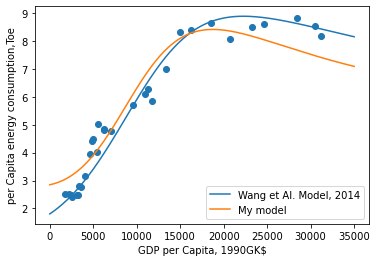

In [9]:
plt.scatter(GDP/pop, PEC/pop)
plt.plot(np.arange(35000), [wang(G) for G in np.arange(35000)], label = 'Wang et Al. Model, 2014')
plt.plot(np.arange(35000), s_curve(dict, np.arange(35000)), label = 'My model')
plt.legend()
plt.xlabel('GDP per Capita, 1990GK$')
plt.ylabel('per Capita energy consumption,Toe')

## Parameters and their analysis 

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]


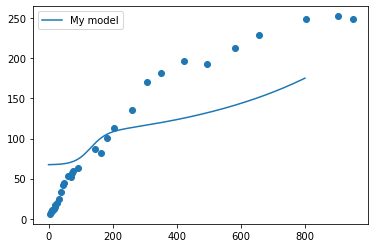

In [10]:
E = PEC/10**4
G = GDP/10**7
dict = remarking_points(G, E, deg=6, step = 0.1)
plt.plot(np.arange(800), s_curve(dict, np.arange(800)), label = 'My model')
plt.legend()
plt.scatter(G,E)

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]


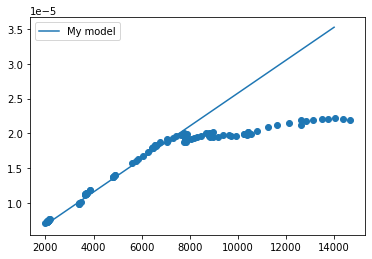

In [11]:
gpec = pd.read_csv('../BDD/global-energy-substitution.csv')
tab = gpec.drop(['Entity', 'Code', 'Year'], axis = 1, inplace = False).to_numpy()
total = np.array([tab[i].sum() for i in range (len(tab))])
gpec['Total (TWh)'] = total
gdp= pd.read_csv('../BDD/world-gdp-over-the-last-two-millennia.csv')
complete  =gpec.merge(gdp, on='Year')
population = pd.read_csv('../BDD/world-population-1750-2015-and-un-projection-until-2100.csv')
final = complete.merge(population, on='Year')
world_data = pd.DataFrame([final['Year'], final['Total (TWh)'], final['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))'], final['World Population over 12000 years (various sources (2019))']]).transpose()
GDP = world_data['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
pop = world_data['World Population over 12000 years (various sources (2019))']
PEC = world_data['Total (TWh)']

E = PEC/pop
G = GDP/pop
dict = remarking_points(G, E, deg=4, step = 0.1)
plt.plot(np.arange(2000, 14000), s_curve(dict, np.arange(2000, 14000)), label = 'My model')
plt.legend()
plt.scatter(G,E)

## Improve curve fitting using scipy

In [12]:
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

def s_model(x, G_i, A, a1, a2, a3):
    """
    s_model(g) = e-E_i
    """
    return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))

def s_curve_fitting(f_model, xdata, ydata, Dy,  bounds = [0, 35000]):
    params = remarking_points(xdata, ydata, deg=6, step = 0.1)
    G_i, E_i= params['inflexion']
    A= abs(params['A'])
    a1 = abs(params['alpha_1'][0])
    a2 = abs(params['alpha_2'][0])
    a3 = abs(params['alpha_3'][0])
    p0 = ( G_i, A, a1, a2, a3)
    y = [ydata[i]-E_i for i in range (len(ydata))]


    popt, pcov = curve_fit(
        f = f_model,       # model function
        xdata=xdata,   # x data
        ydata=y,   # y data
        p0=p0,      # initial value of the parameters
        bounds = bounds,
        sigma=Dy
    )
    return popt, E_i






## USA

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]
<ipython-input-12-f53b63069f67>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))
<ipython-input-12-f53b63069f67>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))


array([1.01195757e+04, 5.04606140e+00, 1.95911358e-10, 3.59417844e-05,
       6.54447598e-05])

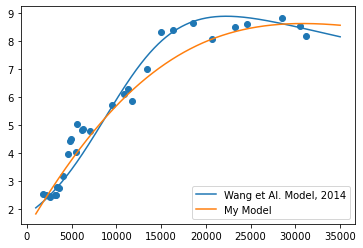

In [13]:
PEC = USA['TotPEC(QuadrillionBTU)']*(2.518272*10**4)
GDP = USA['GDP(1990GK$)']*1000
pop = USA['Pop(000)']
G= GDP/pop
E= PEC/pop
Dy = [np.random.normal(0.3, 0.2) for i in range(len(G))]

popt, E_i = s_curve_fitting(s_model, G, E, Dy)
G_iopt, Aopt, a1opt, a2opt, a3opt = popt
plt.plot(np.arange(1000, 35000), [wang(G) for G in np.arange(1000, 35000)], label = 'Wang et Al. Model, 2014')
plt.plot(np.arange(1000, 35000), s_model(np.arange(1000, 35000), G_iopt, Aopt, a1opt, a2opt, a3opt)+ np.array([E_i for j in range(len(np.arange(1000, 35000)))]),label='My Model')
plt.scatter(G,E)
plt.legend()
popt

In [14]:
gpec = pd.read_csv('../BDD/global-energy-substitution.csv')
tab = gpec.drop(['Entity', 'Code', 'Year'], axis = 1, inplace = False).to_numpy()
total = np.array([tab[i].sum() for i in range (len(tab))])
gpec['Total (TWh)'] = total
gdp= pd.read_csv('../BDD/world-gdp-over-the-last-two-millennia.csv')
complete  =gpec.merge(gdp, on='Year')
population = pd.read_csv('../BDD/world-population-1750-2015-and-un-projection-until-2100.csv')
final = complete.merge(population, on='Year')
world_data = pd.DataFrame([final['Year'], final['Total (TWh)'], final['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))'], final['World Population over 12000 years (various sources (2019))']]).transpose()
GDP = world_data['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
pop = world_data['World Population over 12000 years (various sources (2019))']
PEC = world_data['Total (TWh)']

E = PEC/pop
G = GDP/pop





In [15]:
popt_world


NameError: name 'popt_world' is not defined

## World

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]
<ipython-input-12-f53b63069f67>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))
C:\Users\leatr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


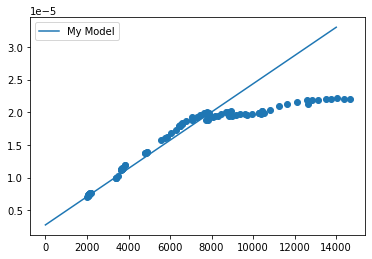

In [22]:
world_data.dropna()
GDP = world_data['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
pop = world_data['World Population over 12000 years (various sources (2019))']
PEC = world_data['Total (TWh)']

E = PEC/pop
G = GDP/pop
Y = world_data['Year']
Dy = [np.random.normal(0.3, 0.2) for i in range(len(G))]
popt_world, E_i = s_curve_fitting(s_model, G, E, Dy, bounds = [0, 15000])
Y_iopt, Aopt, a1opt, a2opt, a3opt = popt_world
plt.plot(np.arange(0,14000), s_model(np.arange(0,14000), Y_iopt, Aopt, a1opt, a2opt, a3opt)+ np.array([E_i for j in range(len(np.arange(0, 14000)))]),label='My Model')
plt.scatter(G,E)
plt.legend()




## PEC

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]
<ipython-input-12-f53b63069f67>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))
C:\Users\leatr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


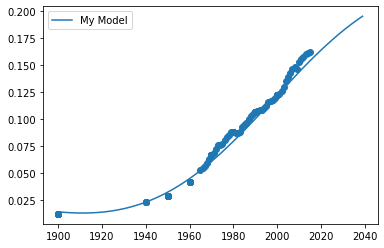

In [23]:
world_data.dropna()
GDP = world_data['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
pop = world_data['World Population over 12000 years (various sources (2019))']
PEC = world_data['Total (TWh)']

G = GDP/pop
Y = world_data['Year']
Dy = None
popt_world, E_i = s_curve_fitting(s_model, Y, PEC/10**6, Dy, bounds = [0, 10**15])
Y_iopt, Aopt, a1opt, a2opt, a3opt = popt_world
plt.plot(np.arange(1900,2040), s_model(np.arange(1900,2040), Y_iopt, Aopt, a1opt, a2opt, a3opt)+ np.array([E_i for j in range(len(np.arange(1900, 2040)))]),label='My Model')
plt.scatter(Y,PEC/10**6)
plt.legend()


In [24]:
popt_world

array([1.99888980e+03, 9.99711755e+00, 4.98242358e-06, 1.37612823e-02,
       2.13941071e-04])

In [25]:
G = GDP/pop
Y = world_data['Year']
Dy = None
popt_world, E_i = s_curve_fitting(s_model, Y, GDP/10**11, Dy, bounds = [0, 200000000])
Y_iopt, Aopt, a1opt, a2opt, a3opt = popt_world
plt.plot(np.arange(1900,200040), s_model(np.arange(1900,200040), Y_iopt, Aopt, a1opt, a2opt, a3opt)+ np.array([E_i for j in range(len(np.arange(1900, 20000000040)))]),label='My Model')

#plt.scatter(Y,GDP/10**11)
plt.legend()


<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]
<ipython-input-12-f53b63069f67>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))
C:\Users\leatr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-12-f53b63069f67>:8: RuntimeWarning: overflow encountered in exp
  return  A*(pd.np.e

MemoryError: Unable to allocate 149. GiB for an array with shape (19999998140,) and data type int64

In [26]:
params = remarking_points(Y, GDP/10**11, deg=6, step = 0.1)
params

<ipython-input-7-4e0f8c730b0f>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-7-4e0f8c730b0f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]


{'inflexion': (1150.8, 34.187537745259704),
 'zero_growth': (767.3000000000001, 1081.2),
 'take_off': (681.1, 34.187537745259704),
 'kl': array([-0.]),
 'ki': 12.146316267456378,
 'kv': array([0.]),
 'A': 9.999725341796875,
 'alpha_1': array([0.60733249]),
 'alpha_2': array([1.21466499]),
 'alpha_3': array([1.21466499])}

In [28]:
new = pd.merge(gdp, gpec, on = ['Year'])[['Year', 'World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))', 'Total (TWh)']]
population.head()
len(population['World Population over 12000 years (various sources (2019))'].dropna())+len(population['Medium Projection (UN Population Division (2019 revision))'].dropna())

tab1 = population[['Year', 'World Population over 12000 years (various sources (2019))']].dropna()
tab1 = tab1.rename(columns = {'World Population over 12000 years (various sources (2019))': 'Population'})
tab2 = population[['Year', 'Medium Projection (UN Population Division (2019 revision))']].dropna()
tab2 = tab2.rename(columns = {'Medium Projection (UN Population Division (2019 revision))': 'Population'})
pop = pd.concat([tab1, tab2])
pd.to_numeric(pop['Year'])
pd.to_numeric(new['Year'])
final=pd.merge(new, pop, on = ['Year'])
time = final['Year']
p = final['Population']
gdp = final['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
energy = final['Total (TWh)']

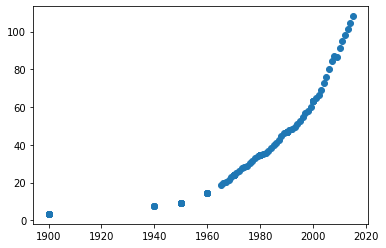

In [29]:
g = gdp/10**12
plt.scatter(time, g)